# Forecasting Usage of New York City's 311 Service  
New York City maintains an information and reporting service for city residents that permit them to source information from and report problems to City Government with greater ease.  While the service is an important enhancement to resident life, it imposes an administrative burden on the City as it must receive the requests and reports and refer them to the correct City agency.  A model that can accurately forecast usage of the service would allow the City to serve residents more efficiently.  
<br>
This analysis will search for a model with stronger predictive power than a baseline model.  Potential models will include:
- ARIMA of varying orders
- SARIMA (ARIMA with seasonality) of varying orders
- SARIMAX (SARIMA with exogenous variables) with various regressors
- Prophet, a newer and more flexible model with better handling of seasonality
- GARCH and GARCH-X, if heteroskedasticity is an issue
- Neural networks (LSTM)

In [1]:
# Import packages

import time
import gc
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from dask import delayed, compute
from dask.distributed import Client
%matplotlib inline

# Models
from arch import arch_model
import pmdarima as pm
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, Dropout, Flatten, GRU, Input, LSTM, MaxPooling1D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 100)

## Data Preparation
The data sources are:  
- NYC OpenData's 311 call database, which includes calls dating from January 1, 2010
- Daily weather for New York City, retrieved from OpenMeteo's API

The '311_Service_Requests' file is over 20 gigabytes.  To improve loading time, this command only imports relevant features and specifies dtypes for each field.

In [3]:
%%time
# Read in 311 data

df_311_calls  = pd.read_csv('Data/311_Service_Requests_20240430.csv',
                            index_col='Unique Key',
                            usecols = ['Agency','Borough','Complaint Type','Created Date','Incident Zip','Unique Key'],
                            dtype = {'Agency':'category','Borough':'category','Complaint Type':str,'Created Date':str,'Incident Zip':str,'Unique Key':'int64'})

df_311_calls = df_311_calls.rename(columns={'Complaint Type': 'Type', 'Created Date': 'Date', 'Incident Zip': 'Zip'})

CPU times: total: 2min 7s
Wall time: 2min 27s


In [4]:
# Initialize Dask client
#client = Client() #'tcp://192.168.4.94:8786')

In [4]:
# Read in NYC zip codes

df_zips = pd.read_csv('Data/uszips/uszips.csv',
                     index_col = 'zip',
                     dtype = {'borough': str, 'zip': str} )

In [6]:
# Load shapefile of zip codes
#filtered_shapefile_path = 'Data/USA_ZIP_Code_Boundaries/filtered_zip_code_shapefile.shp'
#filtered_zip_codes_gdf = gpd.read_file(filtered_shapefile_path)

##### Drop unusable rows

In [5]:
print(f'Initial items: {len(df_311_calls):,.0f}')

Initial items: 36,217,243


In [6]:
# Drop rows with no useable location data
no_loc = df_311_calls['Zip'].isna() #& df_311['Latitude'].isna()
df_311_calls = df_311_calls[~no_loc]
print(f'Rows with locations: {len(df_311_calls):,.0f}')

Rows with locations: 34,682,301


In [7]:
%%time
# Convert date columns to datetime, dropping time component and dropping dates after March 31, 2024
date_format = '%m/%d/%Y %I:%M:%S %p'
df_311_calls['Date'] = pd.to_datetime(df_311_calls['Date'], format=date_format).values.astype('datetime64[D]')
df_311_calls = df_311_calls[df_311_calls['Date'] < pd.Timestamp('2024-04-01')]
print(f'Rows in the date range: {len(df_311_calls):,.0f}')

Rows in the date range: 34,435,921
CPU times: total: 1min 51s
Wall time: 2min 5s


In [8]:
# Convert NaN values in 'Incident Zip' to 'empty', to simplify further processing
df_311_calls['Zip'] = df_311_calls['Zip'].fillna('empty')
df_311_calls.isna().sum()

# Clean up ZIP codes by removing '-####' if present
df_311_calls['Zip'] = df_311_calls['Zip'].str.replace(r'-\d{4}$', '', regex=True)

# Drop all rows with zip codes not in NYC
df_311_calls = df_311_calls[df_311_calls['Zip'].isin(df_zips.index)]
print(f'Rows in NYC: {len(df_311_calls):,.0f}')

Rows in NYC: 34,388,549


In [9]:
# Fill in latitude and longitude when a zip code is available

# Latitude and longitude from US Zip Code file
#zip_to_lat = df_zip['lat'].to_dict()
#zip_to_lng = df_zip['lng'].to_dict()

# Fill in missing latitude and longitude using the mapping, but only if values don't already exist
#df_311.loc[df_311['Latitude'].isna(), 'Latitude'] = df_311['Zip'].map(zip_to_lat)
#df_311.loc[df_311['Longitude'].isna(), 'Longitude'] = df_311['Zip'].map(zip_to_lng)

##### Consolidate Agencies and Types

In [10]:
# Consolidate agencies, replacing minor agencies with 'Other'
agency_dict = {
    'NYPD': 'Police',
    'HPD': 'Housing',
    'DSNY': 'Sanitation',
    'DOT': 'Transportation',
    'DEP': 'Environment',
    'DOB': 'Buildings',
    'DPR': 'Parks',
    'DOMHM': 'Health',
    'DOF': 'Finance',
    'TLC': 'Taxi',
    'DHS': 'Homeless',
    'DCA': 'Consumer',
    'DEPARTMENT OF CONSUMER AND WORKER PROTECTION': 'Consumer',
    'EDC': 'Development',
    'HRA': 'Human Resources',
    'DFTA': 'Aging',
    'OSE': 'ST Rentals',
}

df_311_calls['Agency'] = df_311_calls['Agency'].map(agency_dict).fillna('Other')

In [11]:
# Convert all line items to lowercase
df_311_calls['Type'] = df_311_calls['Type'].str.lower()

In [12]:
# Convert complaint types to fewer categories
complaint_dict = {
    'noise - residential': 'Noise',
    'illegal parking': 'Vehicle',
    'heat/hot water': 'Resident Utility',
    'blocked driveway': 'Vehicle',
    'street condition': 'Street Condition',
    'noise - street/sidewalk': 'Noise',
    'street light condition': 'Traffic Device',
    'request large bulky item collection': 'Item Pickup',
    'plumbing': 'Resident Utility',
    'heating': 'Resident Utility',
    'water system': 'Resident Utility',
    'unsanitary condition': 'Sanitation',
    'noise': 'Noise',
    'general construction/plumbing': 'Resident Utility',
    'traffic signal condition': 'Traffic Device',
    'noise - commercial': 'Noise',
    'paint/plaster': 'Buildings',
    'noise - vehicle': 'Noise',
    'general construction': 'Construction',
    'sewer': 'Sewer',
    'damaged tree': 'Tree',
    'rodent': 'Sanitation',
    'dirty conditions': 'Sanitation',
    'electric': 'Resident Utility',
    'derelict vehicles': 'Vehicle',
    'sanitation condition': 'Sanitation',
    'door/window': 'Buildings',
    'paint - plaster': 'Buildings',
    'sidewalk condition': 'Street Condition',
    'water leak': 'Resident Utility',
    'building/use': 'Buildings',
    'missed collection (all materials)': 'Sanitation',
    'literature request': 'Other',
    'consumer complaint': 'Consumer',
    'general': 'Other',
    'homeless person assistance': 'Social Services',
    'nonconst': 'Other',
    'abandoned vehicle': 'Vehicle',
    'new tree request': 'Tree',
    'flooring/stairs': 'Buildings',
    'graffiti': 'Quality of Life',
    'overgrown tree/branches': 'Tree',
    'non-emergency police matter': 'Police',
    'derelict vehicle': 'Vehicle',
    'maintenance or facility': 'Other',
    'taxi complaint': 'Taxi',
    'appliance': 'Buildings',
    'elevator': 'Buildings',
    'broken muni meter': 'Parking',
    'missed collection': 'Sanitation',
    'noise - helicopter': 'Noise',
    'root/sewer/sidewalk condition': 'Street Condition',
    'food establishment': 'Vendors',
    'for hire vehicle complaint': 'Taxi',
    'dirty condition': 'Sanitation',
    'air quality': 'Environmental',
    'benefit card replacement': 'Social Services',
    'encampment': 'Social Services',
    'dof property - reduction issue': 'Finance',
    'lead': 'Public Health',
    'safety': 'Other',
    'street sign - damaged': 'Traffic Device',
    'illegal fireworks': 'Quality of Life',
    'snow': 'Snow',
    'electronics waste appointment': 'Item Pickup',
    'scrie': 'Housing',
    'dead/dying tree': 'Tree',
    'illegal dumping': 'Sanitation',
    'broken parking meter': 'Parking',
    'other enforcement': 'Police',
    'dof parking - payment issue': 'Finance',
    'indoor air quality': 'Buildings',
    'noise - park': 'Noise',
    'curb condition': 'Street Condition',
    'street sign - missing': 'Traffic Device',
    'noncompliance with phased reopening': 'Public Health',
    'dof property - owner issue': 'Finance',
    'traffic': 'Traffic Device',
    'dof property - request copy': 'Finance',
    'highway condition': 'Street Condition',
    'dead tree': 'Tree',
    'emergency response team (ert)': 'Buildings',
    'special projects inspection team (spit)': 'Construction',
    'water conservation': 'Parks and Rec',
    'dof property - payment issue': 'Finance',
    'hpd literature request': 'Housing',
    'animal abuse': 'Animal',
    'housing - low income senior': 'Housing',
    'drug activity': 'Police',
    'vending': 'Quality of Life',
    'electrical': 'Resident Utility',
    'illegal tree damage': 'Tree',
    'dhs advantage - tenant': 'Housing',
    'food poisoning': 'Public Health',
    'street sign - dangling': 'Traffic Device',
    'violation of park rules': 'Parks and Rec',
    'homeless encampment': 'Social Services',
    'smoking': 'Public Health',
    'animal-abuse': 'Animal',
    'animal in a park': 'Animal',
    'hazardous materials': 'Environmental',
    'obstruction': 'Vehicle',
    'construction': 'Construction',
    'lost property': 'Other',
    'litter basket / request': 'Sanitation',
    'boilers': 'Resident Utility',
    'construction safety enforcement': 'Construction',
    'dhs advantage -landlord/broker': 'Housing',
    'unsanitary animal pvt property': 'Animal',
    'drinking': 'Social Services',
    'residential disposal complaint': 'Sanitation',
    'standing water': 'Environmental',
    'electronics waste': 'Item Pickup',
    'panhandling': 'Social Services',
    'dca / doh new license application request': 'Vendors',
    'asbestos': 'Buildings',
    'dead animal': 'Animal',
    'dof property - update account': 'Finance',
    'outdoor dining': 'Vendors',
    'best/site safety': 'Construction',
    'street sweeping complaint': 'Street Condition',
    'water quality': 'Resident Utility',
    'vendor enforcement': 'Vendors',
    'real time enforcement': 'Buildings',
    'housing options': 'Housing',
    'bus stop shelter complaint': 'Social Services',
    'industrial waste': 'Environmental',
    'bike/roller/skate chronic': 'Quality of Life',
    'mobile food vendor': 'Vendors',
    'overflowing litter baskets': 'Sanitation',
    'derelict bicycle': 'Vehicle',
    'noise survey': 'Noise',
    'non-residential heat': 'Buildings',
    'miscellaneous categories': 'Other',
    'homeless street condition': 'Social Services',
    'noise - house of worship': 'Noise',
    'taxi report': 'Taxi',
    'traffic/illegal parking': 'Vehicle',
    'unleashed dog': 'Animal',
    'indoor sewage': 'Resident Utility',
    'outside building': 'Other',
    'snow or ice': 'Snow',
    'dof parking - request status': 'Finance',
    'unsanitary pigeon condition': 'Animal',
    'sweeping/missed': 'Street Condition',
    'dof parking - request copy': 'Finance',
    'recycling enforcement': 'Sanitation',
    'dpr internal': 'Parks and Rec',
    'urinating in public': 'Social Services',
    'litter basket request': 'Sanitation',
    'day care': 'Social Services',
    'illegal posting': 'Quality of Life',
    'borough office': 'Other',
    'sanitation worker or vehicle complaint': 'Sanitation',
    'vaccine mandate non-compliance': 'Public Health',
    'covid-19 non-essential construction': 'Construction',
    'building marshals office': 'Buildings',
    'commercial disposal complaint': 'Sanitation',
    'dof parking - tax exemption': 'Finance',
    'bridge condition': 'Street Condition',
    'sustainability enforcement': 'Sanitation',
    'taxi compliment': 'Taxi',
    'elder abuse': 'Social Services',
    'sweeping/missed-inadequate': 'Street Condition',
    'disorderly youth': 'Social Services',
    'abandoned bike': 'Vehicle',
    'mold': 'Buildings',
    'dumpster complaint': 'Sanitation',
    'illegal animal kept as pet': 'Animal',
    'mosquitoes': 'Environmental',
    'for hire vehicle report': 'Taxi',
    'drie': 'Housing',
    'found property': 'Other',
    'home delivered meal - missed delivery': 'Social Services',
    'litter basket complaint': 'Sanitation',
    'construction lead dust': 'Environmental',
    'mass gathering complaint': 'Quality of Life',
    'cranes and derricks': 'Construction',
    'dof property - rpie issue': 'Finance',
    'posting advertisement': 'Quality of Life',
    'home repair': 'Buildings',
    'harboring bees/wasps': 'Animal',
    'scaffold safety': 'Construction',
    'adopt-a-basket': 'Sanitation',
    'senior center complaint': 'Social Services',
    'plant': 'Other',
    'window guard': 'Buildings',
    'sewer maintenance': 'Sewer',
    'snow removal': 'Snow',
    'sweeping/inadequate': 'Street Condition',
    "alzheimer's care": 'Social Services',
    'beach/pool/sauna complaint': 'Parks and Rec',
    'city vehicle placard complaint': 'Other',
    'drinking water': 'Resident Utility',
    'collection truck noise': 'Sanitation',
    'question': 'Other',
    'facades': 'Buildings',
    'private or charter school reopening': 'Public Health',
    'dof property - property value': 'Finance',
    'dof parking - dmv clearance': 'Finance',
    'request xmas tree collection': 'Item Pickup',
    'poison ivy': 'Environmental',
    'oem disabled vehicle': 'Vehicle',
    'uprooted stump': 'Tree',
    'wood pile remaining': 'Construction',
    'face covering violation': 'Public Health',
    'tattooing': 'Other',
    'heap assistance': 'Resident Utility',
    'highway sign - damaged': 'Traffic Device',
    'quality of life': 'Quality of Life',
    'utility program': 'Resident Utility',
    'executive inspections': 'Buildings',
    'forms': 'Other',
    'dhs advantage - third party': 'Public Health',
    'unsanitary animal facility': 'Vendors',
    'green taxi complaint': 'Taxi',
    'dof property - city rebate': 'Finance',
    'forensic engineering': 'Buildings',
    'weatherization': 'Buildings',
    'pet shop': 'Vendors',
    'animal facility - no permit': 'Vendors',
    'special natural area district (snad)': 'Parks and Rec',
    'municipal parking facility': 'Parking',
    'home delivered meal complaint': 'Social Services',
    'illegal animal sold': 'Animal',
    'seasonal collection': 'Item Pickup',
    'dep street condition': 'Street Condition',
    'stalled sites': 'Other',
    'advocate-personal exemptions': 'Finance',
    'highway sign - missing': 'Traffic Device',
    'ahv inspection unit': 'Vendors',
    'e-scooter': 'Quality of Life',
    'public toilet': 'Parks and Rec',
    'eviction': 'Housing',
    'fatf': 'Finance',
    'dof parking - address update': 'Parking',
    'advocate-prop refunds/credits': 'Finance',
    'water maintenance': 'Resident Utility',
    'highway sign - dangling': 'Traffic Device',
    'parking card': 'Parking',
    'taxpayer advocate inquiry': 'Finance',
    'summer camp': 'Parks and Rec',
    'special operations': 'Quality of Life',
    'incorrect data': 'Other',
    'bereavement support group': 'Social Services',
    'advocate - other': 'Social Services',
    'lifeguard': 'Parks and Rec',
    'squeegee': 'Quality of Life',
    'x-ray machine/equipment': 'Other',
    'home care provider complaint': 'Social Services',
    'case management agency complaint': 'Social Services',
    'atf': 'Police',
    'private school vaccine mandate non-compliance': 'Public Health',
    'overflowing recycling baskets': 'Sanitation',
    'comments': 'Other',
    'cooling tower': 'Buildings',
    'recycling basket complaint': 'Sanitation',
    'calorie labeling': 'Vendors',
    'legal services provider complaint': 'Social Services',
    'health': 'Public Health',
    'radioactive material': 'Environmental',
    'dhs income savings requirement': 'Housing',
    'institution disposal complaint': 'Sanitation',
    'water drainage': 'Environmental',
    'green taxi report': 'Taxi',
    'peeling paint': 'Buildings',
    'tunnel condition': 'Street Condition',
    'building drinking water tank': 'Buildings',
}    

In [13]:
df_311_calls['Type'] = df_311_calls['Type'].map(complaint_dict).fillna('Other')

#### Visualize Distributions

In [14]:
# Clean Borough values for charting
df_311_calls['Borough'] = df_311_calls['Borough'].str.title()

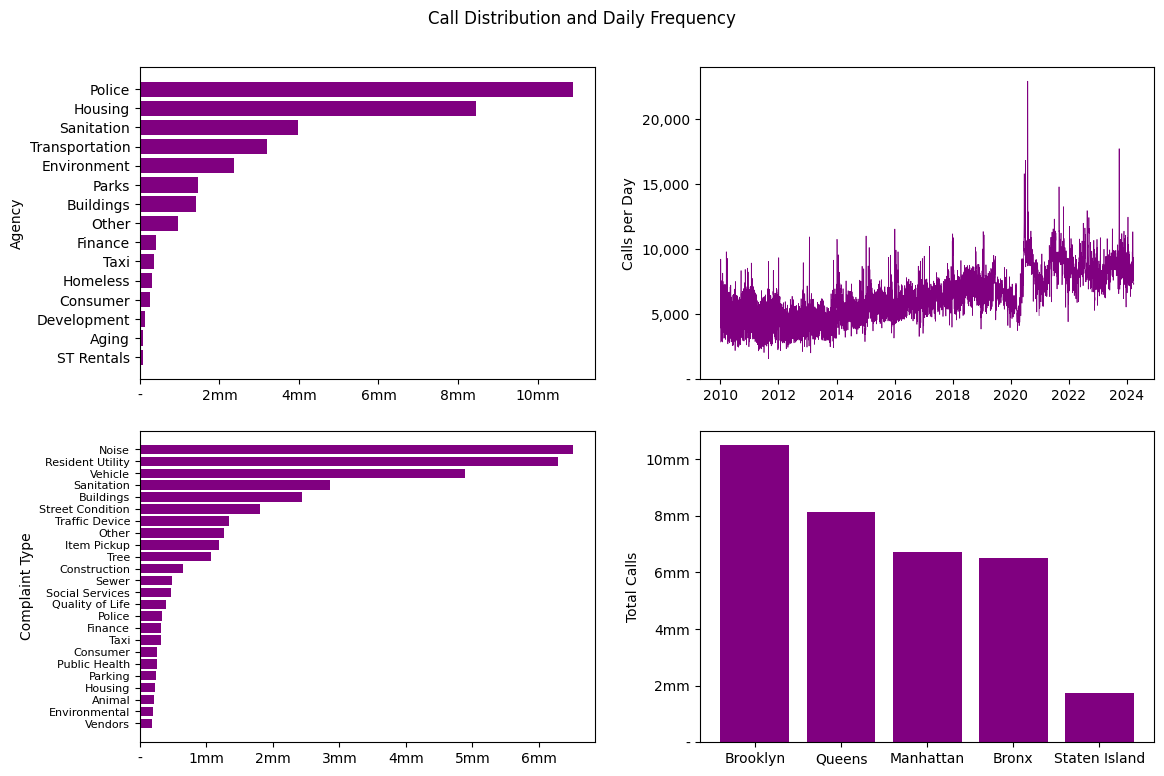

In [15]:
# Visualize call data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12,8))
fig.suptitle('Call Distribution and Daily Frequency')
ax1.barh(y = df_311_calls['Agency'].value_counts().sort_values(ascending=True).index[1:], width = df_311_calls['Agency'].value_counts().sort_values(ascending=True)[1:], color='purple')
ax1.set_xticks([0,2000000,4000000,6000000,8000000,10000000])
ax1.set_xticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax1.set_ylabel('Agency')
ax2.plot(df_311_calls['Date'].value_counts().sort_index(), linewidth=0.5, color='purple')
ax2.set_yticks([0,5000,10000,15000,20000])
ax2.set_yticklabels(['-','5,000','10,000','15,000','20,000'])
ax2.set_ylabel('Calls per Day')
ax3.barh(y= df_311_calls['Type'].value_counts().sort_values(ascending=True).index[2:], width = df_311_calls['Type'].value_counts().sort_values(ascending=True)[2:], color='purple')
ax3.tick_params(axis='y', labelsize=8)
ax3.set_xticks([0,1000000,2000000,3000000,4000000,5000000,6000000])
ax3.set_xticklabels(['-','1mm','2mm','3mm','4mm','5mm','6mm'])
ax3.set_ylabel('Complaint Type')
ax4.bar(x=df_311_calls['Borough'].value_counts().sort_values(ascending=False)[:-1].index, height=df_311_calls['Borough'].value_counts().sort_values(ascending=False)[:-1], color='purple')
ax4.set_yticks([0,2000000,4000000,6000000,8000000,10000000])
ax4.set_yticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax4.set_ylabel('Total Calls')
plt.tight_layout(pad=2.0)
plt.show()

### Weather

In [16]:
# Read in NYC weather data, and format
df_weather = pd.read_csv('Data/NYC_weather_data.csv')
df_weather.drop('Unnamed: 0', axis=1, inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['date']).values.astype('datetime64[D]')
df_weather.set_index('date',inplace=True)
df_weather.drop_duplicates(inplace=True)
df_weather = df_weather[df_weather.index < pd.Timestamp('2024-04-01')]
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5204 entries, 2010-01-01 to 2024-03-31
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   temperature_2m_max   float64
 1   temperature_2m_min   float64
 2   temperature_2m_mean  float64
 3   daylight_duration    float64
 4   rain_sum             float64
 5   snowfall_sum         float64
 6   wind_speed_10m_max   float64
dtypes: float64(7)
memory usage: 325.2 KB


#### Visualize

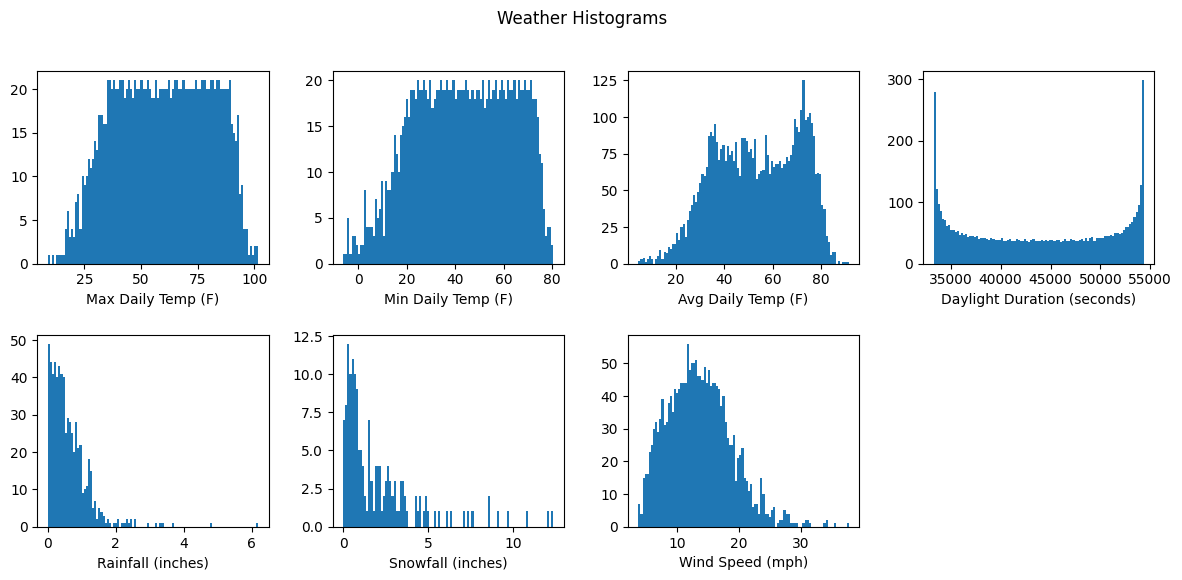

In [17]:
# Visualize weather data
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle('Weather Histograms')
ax1.hist(df_weather['temperature_2m_max'].value_counts().index, bins=100)
ax1.set_xlabel('Max Daily Temp (F)')
ax2.hist(df_weather['temperature_2m_min'].value_counts().index, bins=100)
ax2.set_xlabel('Min Daily Temp (F)')
ax3.hist(df_weather['temperature_2m_mean'].value_counts().index, bins=100)
ax3.set_xlabel('Avg Daily Temp (F)')
ax4.hist(df_weather['daylight_duration'].value_counts().index, bins=100)
ax4.set_xlabel('Daylight Duration (seconds)')
ax5.hist(df_weather['rain_sum'].value_counts().index, bins=100)
ax5.set_xlabel('Rainfall (inches)')
ax6.hist(df_weather['snowfall_sum'].value_counts().index, bins=100)
ax6.set_xlabel('Snowfall (inches)')
ax7.hist(df_weather['wind_speed_10m_max'].value_counts().index, bins=100)
ax7.set_xlabel('Wind Speed (mph)')
ax8.axis('off')
plt.tight_layout(pad=2.0)
plt.show;

#### Scaling
- Rainfall, snowfall and wind speed: Box-Cox transformation, addresses right-skewed distributions
- Temperatures - Temperatures are normally distributed when holding seasonality constant.  Seasonal decompose first, then standard scale, then seasonal recompose
- Daylight Duration - Minmax scaling

In [18]:
# Scaling functions for weather data

# log transform with a small constant
def log_transform(series, constant=1e-6):
    return np.log(series + constant)

# Helper function to apply Box-Cox transformation
def boxcox_transform(series):
    series_nonzero = series + 1e-6  # Add small constant to avoid zero values
    transformed_data, _ = boxcox(series_nonzero)
    return pd.Series(transformed_data, index=series.index)

# Seasonal decompose and recompose function
def decompose_and_scale(series, period=365):
    series = series.dropna()  # Drop NaNs if any
    decomposition = seasonal_decompose(series, model='additive', period=period)
    seasonal = decomposition.seasonal
    adjusted_series = series - seasonal  # Adjust the original series by removing the seasonal component

    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(adjusted_series.values.reshape(-1, 1))

    scaled_series_full = pd.Series(scaled_series.flatten(), index=adjusted_series.index)
    scaled_series_full = scaled_series_full.reindex(series.index).bfill().ffill()

    return scaled_series_full


In [19]:
# Applying transformations

# Temperature columns: seasonal decompose, scale, recompose
df_weather['temperature_2m_max_scaled'] = decompose_and_scale(df_weather['temperature_2m_max'])
df_weather['temperature_2m_min_scaled'] = decompose_and_scale(df_weather['temperature_2m_min'])
df_weather['temperature_2m_mean_scaled'] = decompose_and_scale(df_weather['temperature_2m_mean'])

# Daylight duration: MinMax scale
df_weather['daylight_duration_scaled'] = MinMaxScaler().fit_transform(df_weather['daylight_duration'].values.reshape(-1, 1))

# Rainfall and Snowfall: Log transform with small constant
df_weather['rain_sum_log'] = boxcox_transform(df_weather['rain_sum'])
df_weather['snowfall_sum_log'] = boxcox_transform(df_weather['snowfall_sum'])

# Wind speed: Log transform
df_weather['wind_speed_10m_max_log'] = boxcox_transform(df_weather['wind_speed_10m_max'])

# Dropping original columns if no longer needed
df_weather.drop(columns=['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
                         'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max'], inplace=True)

# Renaming the transformed columns
df_weather.rename(columns={
    'temperature_2m_max_scaled': 'temperature_2m_max',
    'temperature_2m_min_scaled': 'temperature_2m_min',
    'temperature_2m_mean_scaled': 'temperature_2m_mean',
    'daylight_duration_scaled': 'daylight_duration',
    'rain_sum_log': 'rain_sum',
    'snowfall_sum_log': 'snowfall_sum',
    'wind_speed_10m_max_log': 'wind_speed_10m_max'
}, inplace=True)

# Displaying the transformed dataframe
df_weather.head()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,daylight_duration,rain_sum,snowfall_sum,wind_speed_10m_max
date,,,,,,,
2010-01-01,0.175818,-0.667740,-0.294884,0.011686,-5.086032,-1.473707e+00,1.872807
2010-01-02,-1.375657,-2.075379,-1.380453,0.013809,-6.568085,-2.786367e+00,2.729425
2010-01-03,-2.189736,-2.108758,-2.462976,0.016103,-21.517231,-9.017416e+00,2.970008
2010-01-04,-1.001858,-0.838221,-1.217928,0.018563,-21.517231,-2.600800e+06,2.462322
2010-01-05,-1.339170,-1.280739,-1.694560,0.021189,-21.517231,-2.600800e+06,2.330225


## Modeling
- Perform Baseline model, 1 day shift (equal to ARIMA(0,1,0))
- Step up to ARIMA model to see if performance can be improved
- Search for seasonality (weekly and annually) and apply SARIMA if found
- SARIMA can only handle one dimension of seasonality, consider TBATs for more than one period
  

In [20]:
# Identify future target columns
target_cols = ['Agency', 'Type', 'Zip', 'Borough']

# Create Master dataset to use for modeling
df_311_dates = df_311_calls.drop(columns=target_cols, axis=1)
time_series = df_311_dates.groupby('Date').size().reset_index(name='Count')
time_series.set_index('Date', inplace=True)

# Dummy for COVID period  ###################### should change this to covid lockdowns
lockdown1 = pd.date_range(start='2020-03-21', end='2020-06-06', inclusive='both')
lockdown2 = pd.date_range(start='2021-07-09', end='2021-10-27', inclusive='both')
lockdown3 = pd.date_range(start='2021-02-13', end='2021-02-17', inclusive='both')
lockdown4 = pd.date_range(start='2021-05-28', end='2021-06-10', inclusive='both')
lockdowns = lockdown1.union(lockdown2).union(lockdown3).union(lockdown4)

time_series['covid'] = time_series.index.isin(lockdowns) * 1
time_series['winter'] = (time_series.index.month <= 2) * 1
time_series['weekend'] = (time_series.index.dayofweek >= 5) * 1
time_series['311_app'] = (time_series.index >= pd.Timestamp('2013-03-19')) * 1

time_series = pd.concat([time_series, df_weather], axis=1)

In [21]:
# Interpolate NYC population using US Census estimates
population_data = {
    'date': pd.to_datetime(['2010-01-01', '2010-07-01', '2011-07-01', '2012-07-01', '2013-07-01', '2014-07-01',
                            '2015-07-01', '2016-07-01', '2017-07-01', '2018-07-01', '2019-07-01',
                            '2020-04-01', '2020-07-01', '2021-07-01', '2022-07-01', '2023-07-01', '2024-03-31']),
    'population': [8175133, 8190209, 8251281, 8312676, 8374527, 8436839, 8499614, 8562857, 8626570, 8690757, 8755421, 8804199, 8740292, 8462216, 8335798, 8258035, 8200257]
}

# Create DataFrame
population_df = pd.DataFrame(population_data)

# Set the date as index
population_df.set_index('date', inplace=True)

# Generate a date range from 2010-01-01 to 2024-03-31
date_range = pd.date_range(start='2010-01-01', end='2024-03-31', freq='D')

# Reindex the population data to the full date range, using interpolation to fill in the gaps
population_daily_df = population_df.reindex(date_range)
population_daily_df['population'] = population_daily_df['population'].interpolate(method='linear')

# Scale population numbers
population_daily_df['population'] = MinMaxScaler().fit_transform(population_daily_df['population'].values.reshape(-1, 1))

time_series = pd.concat([time_series, population_daily_df], axis=1)
time_series = time_series.asfreq('D')

In [22]:
# Create training and testing data sets with a train-test split
split_point = int(len(time_series) * 0.8)
train_df = time_series.iloc[:split_point]
test_df = time_series[split_point:]

### Choosing a Baseline Model
Three different models could serve as a baseline for a time series problem.  Each is assessed below:
- First order regressive, or AR(1)
- Random walk
- First order moving average, or MA(1)  

In [45]:
def fit_arima(history, pdq):
    model = ARIMA(history, order=pdq)
    model_fit = model.fit(method_kwargs={"maxiter": 1000})
    return model_fit

def arima_rolling_forecast(train_series: pd.Series,
                           test_series: pd.Series,
                           pdq: tuple[int, int, int]) -> tuple[float, pd.Series, list]:
    # Initialize the training data
    history = list(train_series)
    predictions = []
    total_steps = len(test_series)

    # Start a Dask client
#    client = Client()

    for t in range(total_steps):
#        delayed_fit = delayed(fit_arima)(history, pdq)
#        model_fit = delayed_fit.compute(scheduler='threads')  # Use threads for parallel execution
        model_fit = fit_arima(history, pdq)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test_series.iloc[t])

        # Report progress
        if (t + 1) % 100 == 0 or (t + 1) == total_steps:
            print(f"Progress: {t + 1} out of {total_steps} steps completed")

    # Calculate MAPE
    arima_mape = mean_absolute_percentage_error(test_series, predictions)

    # Get predictions for the training set (using the last fitted model)
    train_pred = model_fit.predict(start=0, end=len(train_series) - 1)

#    client.close()
    
    return arima_mape, train_pred, predictions

In [46]:
def plot_forecast(train_series: pd.Series,
                  test_series: pd.Series,
                  train_pred: pd.Series,
                  test_pred: list,
                  title: str) -> None:
    fig, ax = plt.subplots(figsize=(13, 3))
    ax.plot(train_series.index, train_pred, label='Training Prediction', color='blue', alpha=0.6)
    ax.plot(test_series.index, test_pred, label='Test Prediction', color='orange', alpha=0.6)
    ax.scatter(train_series.index, train_series,
               alpha=0.3, label='Training Data', color='blue', edgecolors='black', linewidths=.5, s=10)
    ax.scatter(test_series.index, test_series,
               alpha=0.3, label='Testing Data', color='orange', edgecolors='black', linewidths=.5, s=10)

    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title(f'{title}')
    plt.legend()
    plt.show()

##### AR(1) Model

C:\Program Files\Python312\Lib\site-packages\dask\base.py:1462: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


Progress: 100 out of 1041 steps completed
Progress: 200 out of 1041 steps completed
Progress: 300 out of 1041 steps completed
Progress: 400 out of 1041 steps completed
Progress: 500 out of 1041 steps completed
Progress: 600 out of 1041 steps completed
Progress: 700 out of 1041 steps completed
Progress: 800 out of 1041 steps completed
Progress: 900 out of 1041 steps completed
Progress: 1000 out of 1041 steps completed
Progress: 1041 out of 1041 steps completed


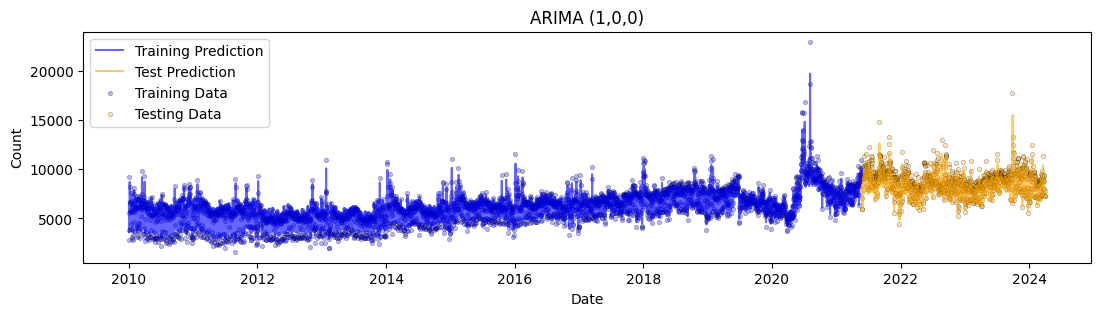

MAPE: 0.0954
CPU times: total: 1min 31s
Wall time: 3min 56s


In [44]:
%%time
# ARIMA (1, 0, 0)
mape_arima_100, train_pred_arima_100, predictions_arima_100 = arima_rolling_forecast(train_df['Count'], test_df['Count'], (1, 0, 0))
plot_forecast(train_df['Count'], test_df['Count'], train_pred_arima_100, predictions_arima_100, "ARIMA (1,0,0)")
print(f'MAPE: {mape_arima_100:.4f}')

<br> 2 54 with no dask
2 26 with local dask

##### Random Walk

Progress: 100 out of 1041 steps completed
Progress: 200 out of 1041 steps completed
Progress: 300 out of 1041 steps completed
Progress: 400 out of 1041 steps completed
Progress: 500 out of 1041 steps completed
Progress: 600 out of 1041 steps completed
Progress: 700 out of 1041 steps completed
Progress: 800 out of 1041 steps completed
Progress: 900 out of 1041 steps completed
Progress: 1000 out of 1041 steps completed
Progress: 1041 out of 1041 steps completed


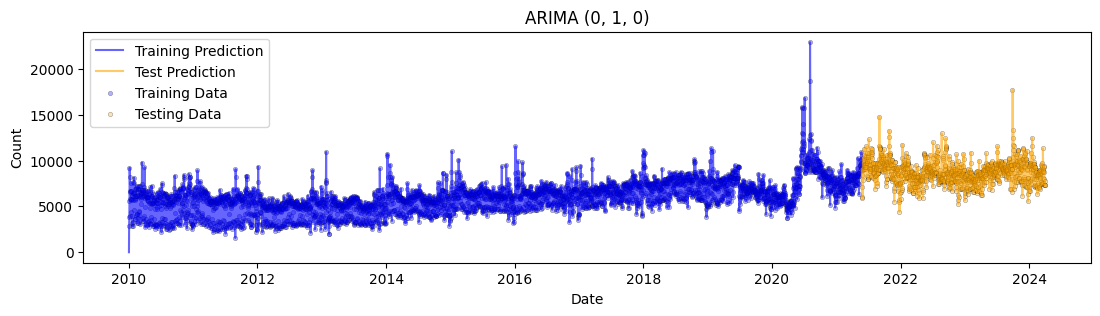

MAPE: 0.0910
CPU times: total: 18.8 s
Wall time: 41.7 s


In [47]:
%%time
# ARIMA (0, 1, 0)
mape_arima_010, train_pred_arima_010, predictions_arima_010 = arima_rolling_forecast(train_df['Count'], test_df['Count'], (0, 1, 0))
plot_forecast(train_df['Count'], test_df['Count'], train_pred_arima_010, predictions_arima_010, "ARIMA (0, 1, 0)")
print(f'MAPE: {mape_arima_010:.4f}')

<br>

##### MA(1) Model

In [48]:
%%time
# ARIMA (0, 0, 1)
mape_arima_001, train_pred_arima_001, predictions_arima_001 = arima_rolling_forecast(train_df['Count'], test_df['Count'], (0, 0, 1))
plot_forecast(train_df['Count'], test_df['Count'], train_pred_arima_001, predictions_arima_001, "ARIMA (0, 0, 1)")
print(f'MAPE: {mape_arima_001:.4f}')

KeyboardInterrupt: 

<br>

**Random Walk is the baseline**: Random Walk and MA(1) both have 9.1% average percentage errors.  This will serve as the comparison going forward.

<br>

### First Simple Model: ARIMA
ARIMA will look for autoregressive and moving average terms that will lead to improvements against the baseline.  ARIMA models are applied to "stationary" data sets.  The Augmented Dickey-Fuller test will test to determine whether this data is stationary.  Large negative statistics, and p-values under 0.05, imply that the data *is* stationary. 

In [73]:
result = adfuller(time_series['Count'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.5208859123946588
p-value: 0.11047490316084208


<b><span style="color:red">Not stationary</span></b>.  Because the p-value is not less than 0.05, the data is not stationary and must be transformed.  The first transformation will use the one-day difference.

In [74]:
# Transform the data by taking the one-day difference
time_series['Count_diff'] = time_series['Count'].diff().dropna()
result_diff = adfuller(time_series['Count_diff'].dropna())
print(f'ADF Statistic (1st diff): {result_diff[0]}')
print(f'p-value (1st diff): {result_diff[1]}')

ADF Statistic (1st diff): -21.56754139806522
p-value (1st diff): 0.0


<b><span style="color:#15B01A">Stationary</span></b>.  The data is now stationary so the future 'd' term will be 1.  Now, the Autocorrelation Function CF and PACF to look for good p and q terms, and check for seasonality. 

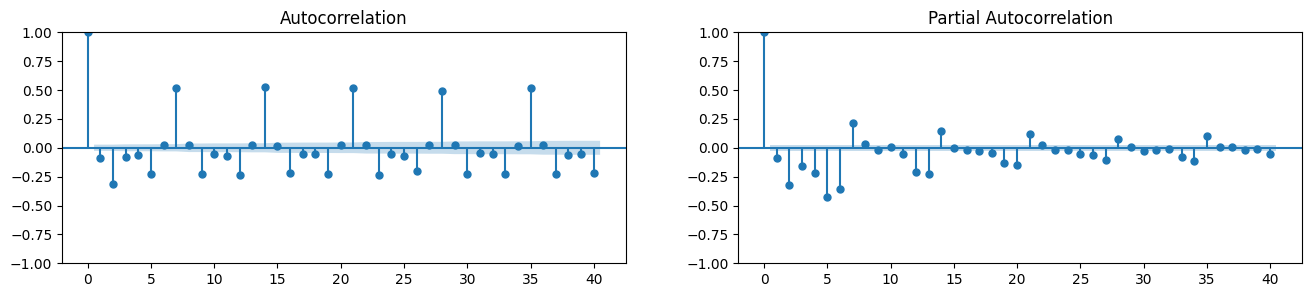

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(time_series['Count_diff'].dropna(), lags=40, ax=axes[0])
plot_pacf(time_series['Count_diff'].dropna(), lags=40, ax=axes[1]);

The drop-off after 1 term in each chart suggests that p=1 and q=1 will lead to better results.  However, the oscillation makes it difficult to determine what the right term actually will be.  Notably, the 7-day pattern outside of the confidence interval suggests seasonality.

Forecast ARIMA (1,1,1) based on visual inspection.  Then run a grid search to recommend the best set of 'pdq' to use.

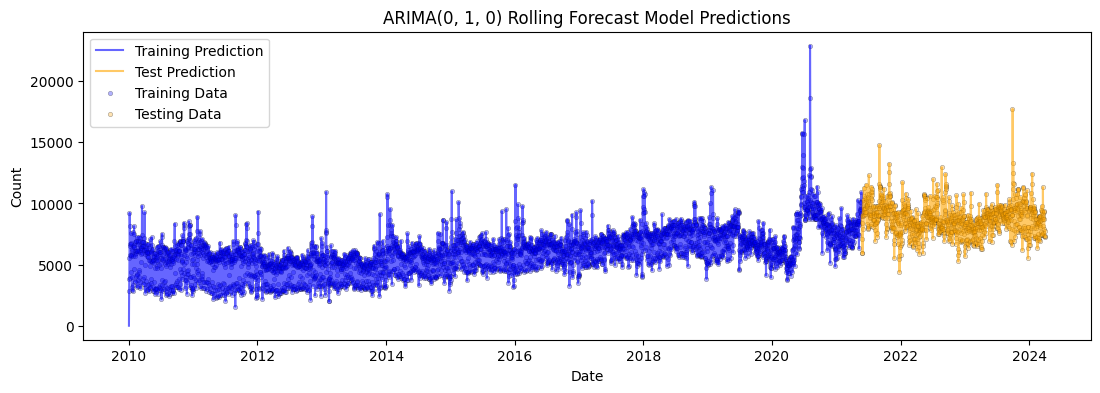

CPU times: total: 22.2 s
Wall time: 38.2 s


,ARIMA
Order,"(0, 1, 0)"
MAPE,0.091


In [71]:
%%time
# ARIMA (1, 1, 1)
mape_arima_111, train_pred_arima_111, predictions_arima_111 = arima_rolling_forecast(train_df['Count'], test_df['Count'], (1, 1, 1))
plot_forecast(train_df['Count'], test_df['Count'], train_pred_arima_111, predictions_arima_111, "ARIMA (1, 1, 1)")
print(f'MAPE: {mape_arima_111:.4f}')

In [80]:
%%time

# Set up Dask client
client = Client('192.168.4.40:8786')

# Specify all iterations of pdq
p = q = range(0, 8)
d = range(0,3)
arima_pdq = list(itertools.product(p, d, q))

# Set up logging
logging.basicConfig(level=logging.INFO, filename='arima_grid_search.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Function to fit ARIMA model and calculate AIC
def fit_arima(train, param):
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit(method_kwargs={"maxiter": 1000})
        aic = model_fit.aic
        logging.info(f'Successfully fitted ARIMA model with parameters {param}, AIC: {aic:.4f}')
        return aic, param
    except Exception as e:
        logging.error(f'Error fitting ARIMA model with parameters {param}: {e}')
        return np.inf, param

# Function to perform cross-validation and calculate mean AIC
def cross_validate_arima(train, param, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    aic_scores = []
    for train_index, test_index in tscv.split(train):
        train_fold = train[train_index]
        aic, _ = fit_arima(train_fold, param)
        aic_scores.append(aic)
    mean_aic = np.mean(aic_scores)
    return mean_aic, param

# Wrap the function call with Dask delayed
tasks = [delayed(cross_validate_arima)(train_df['Count'].values, param) for param in arima_pdq]

# Compute the results in parallel
results = compute(*tasks)

# Create DataFrame to store results
results_df = pd.DataFrame(results, columns=['AIC', 'pdq'])
results_df = results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
results_df

# Shutdown Dask client
client.close()


CPU times: total: 188 ms
Wall time: 17min 23s


In [81]:
results_df.T

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
AIC,27140.618268,27351.951439,28022.195322,32153.438913,33232.909,33411.492154,33458.636949,33461.073354,33469.856374,33551.924388,...,35841.016292,35843.54302,35847.258454,36091.472312,36177.209353,36459.840175,36481.9248,36621.574455,37083.774149,37377.084843
pdq,"(1, 2, 3)","(2, 1, 6)","(2, 2, 2)","(2, 1, 5)","(7, 1, 7)","(7, 0, 7)","(7, 0, 6)","(6, 1, 7)","(7, 1, 6)","(7, 2, 7)",...,"(0, 2, 1)","(1, 1, 0)","(0, 1, 0)","(0, 0, 0)","(5, 2, 0)","(4, 2, 0)","(3, 2, 0)","(2, 2, 0)","(1, 2, 0)","(0, 2, 0)"


<br>

The grid search identifies (3,1,3) as the model with the lowest MAPE.  However, (1,1,1) is much lower-order and may have similar performance.  Both will be tested.

In [82]:
%%time
# Create empty dataframe for results
results_compare = pd.DataFrame()

# ARIMA (1, 2, 3)
results_compare = rolling_forecast_arima(train_df['Count'], test_df['Count'], (1, 2, 3), results_compare, model_name='ARIMA')
results_compare

C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

In [ ]:
# ARIMA (optimal)
results_compare = rolling_forecast_arima(train_df['Count'], test_df['Count'], arima_best_pdq, results_compare, model_name='ARIMA Optimal')
results_compare

In [ ]:
# ARIMA(1,1,1) (alternative)
results_compare = rolling_forecast_arima(train_df['Count'], test_df['Count'], (1,1,1), results_compare, model_name='ARIMA Alternative')
results_compare

The lower-order alternative ARIMA model is almost as good as the higher-order ARIMA.  If complexity were a concern, (1,1,1) would be a good fallback option.
<br>


### SARIMA for seasonality
The ACF/PACF plots suggested seasonality.  SARIMA is a form of ARIMA model that detects and models seasonality as well (though only one form).  Like ARIMA, SARIMA requires stationary data.  The ADF test showed that undifferenced data taking the seasonal difference

In [ ]:
time_series['week_diff'] = time_series['Count_diff'].diff(7)
results_adf_7d = adfuller(time_series['week_diff'].dropna())
print(f'ADF Statistic (1st diff): {results_adf_7d[0]}')
print(f'p-value (1st diff): {results_adf_7d[1]}')

7-day differencing results in stationarity.  'D' term will be 1 as well.

In [ ]:
# Plot ACF and PACF of seasonally differenced residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 2))
plot_acf(time_series['week_diff'].dropna(), ax=ax[0], lags=50)
plot_pacf(time_series['week_diff'].dropna(), ax=ax[1], lags=50)
plt.tight_layout()
plt.show()

**MA(Q) = 1**:  The ACF chart rebounds to zero by the second week.  
**AR(P) = 6**:  The PACF chart appears to rebound to zero by the sixth week.  
<br>
The first SARIMA model should try (1,1,1) (6,1,1) with 7-day seasonality.  Once again, we'll use a grid search to find the best model, but since we know that AIC sometimes returns sub-optimal models, we will select for lowest MAPE on the test set.

In [ ]:
%%time
# Function to fit SARIMA and calculate MAPE
def fit_sarima(train, test, param, seasonal_param):
    try:
        model = SARIMAX(train, order=param, seasonal_order=seasonal_param)
        results = model.fit(disp=False, maxiter=2000, method='powell')
        predictions = results.get_forecast(steps=len(test)).predicted_mean
        mape = mean_absolute_percentage_error(test, predictions)
        del model, results, predictions
        logging.info(f'Successfully fitted SARIMA model with parameters {param}x{seasonal_param}, MAPE: {mape}')
        return mape, param, seasonal_param
    except Exception as e:
        logging.error(f'Error fitting SARIMA model with parameters {param}x{seasonal_param}: {e}')
        return np.inf, param, seasonal_param

In [ ]:
%%time
# Define the range for p, q, P, Q
p = q = range(1, 4)
P = Q = range(0, 5)
d = D = 1
seasonal_period = 7

# Generate all combinations of p, d, q and P, D, Q
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = list(itertools.product(P, [D], Q, [seasonal_period]))

# Create delayed tasks for Dask
tasks = [
    delayed(fit_sarima)(train_df['Count'], test_df['Count'], param, seasonal_param)
    for param in pdq
    for seasonal_param in seasonal_pdq
]

# Compute the results using Dask
results = compute(*tasks)

# Extract the best model based on MAPE
best_mape, best_pdq, best_seasonal_pdq = min(results, key=lambda x: x[0])

# Print the best model and its parameters
print(f'Best SARIMA model: {best_pdq}x{best_seasonal_pdq} with MAPE {best_mape:.4f}')

In [ ]:
# Define optimization methods to try
optimization_methods = ['powell', 'cg', 'bfgs', 'lbfgs', 'nm', 'basinhopping']

def fit_sarima_opt(train_data, val_data, method):
    try:
        model = SARIMAX(train_data, order=(1, 1, 3), seasonal_order=(3, 1, 3, 7))
        results = model.fit(method=method, maxiter=2000)
        predictions = results.get_forecast(steps=len(val_data)).predicted_mean
        mape = mean_absolute_percentage_error(val_data, predictions)
        logging.info(f'Method: {method}, MAPE: {mape}')
        return mape, method
    except Exception as e:
        logging.error(f'Error fitting SARIMA model with method {method}: {e}')
        return float('inf'), method
        
k = 5
tscv = TimeSeriesSplit(n_splits=k)

best_mape = float('inf')
best_optimization_method = None

# Define delayed tasks for Dask
delayed_tasks = []
for train_index, val_index in tscv.split(train_df['Count']):
    train_data, val_data = train_df['Count'].iloc[train_index], train_df['Count'].iloc[val_index]
    for method in optimization_methods:
        delayed_tasks.append(delayed(fit_sarima_opt)(train_data, val_data, method))

# Compute the results using Dask
results = compute(*delayed_tasks)

# Process the results
for result in results:
    mape, method = result
    if mape < best_mape:
        best_mape = mape
        best_optimization_method = method

print(f'Best SARIMA model: Optimization Method: {best_optimization_method}, MAPE: {best_mape}')

In [ ]:
@delayed
def fit_and_evaluate_sarima(train_data, val_data):
    try:
        sarima_model = SARIMAX(train_data,
                               order=(1, 1, 1), 
                               seasonal_order=(1, 1, 1, 7),
                               enforce_stationarity=False, 
                               enforce_invertibility=False)
        sarima_results = sarima_model.fit(disp=False, maxiter=2000, method='powell')
        sarima_pred = sarima_results.get_forecast(steps=len(val_data))
        sarima_y_pred = sarima_pred.predicted_mean

        # Calculate evaluation metrics
        sarima_mape = mean_absolute_percentage_error(val_data, sarima_y_pred)

        logging.info(f'MAPE: {sarima_mape}')

        return sarima_mape, val_data, sarima_y_pred
    except Exception as e:
        logging.error(f'Error fitting SARIMA model: {e}')
        return float('inf'), [], []

# Cross-validation setup
k = 5
tscv = TimeSeriesSplit(n_splits=k)

# Define delayed tasks for Dask
delayed_tasks = []
for train_index, val_index in tscv.split(train_df['Count']):
    train_data, val_data = train_df['Count'].iloc[train_index], train_df['Count'].iloc[val_index]
    delayed_tasks.append(delayed(fit_and_evaluate_sarima)(train_data, val_data))

# Compute the results using Dask
results = compute(*delayed_tasks)

# Aggregate the cross-validation results
aggregated_results = {
    'mape': np.mean([result[1] for result in results]),
}

print("Cross-Validation Results:")
print(f"MAPE: {aggregated_results['mape']}")

# Fit the final model on the entire training dataset and evaluate on the test dataset
final_sarima_model = SARIMAX(train_df['Count'],
                             order=(1, 1, 1), 
                             seasonal_order=(1, 1, 1, 7),
                             enforce_stationarity=False, 
                             enforce_invertibility=False)
final_sarima_results = final_sarima_model.fit(disp=False, maxiter=2000, method='powell')
final_sarima_pred = final_sarima_results.get_forecast(steps=len(test_df))
final_sarima_y_pred = final_sarima_pred.predicted_mean

# Calculate final evaluation metrics
final_sarima_mape = mean_absolute_percentage_error(test_df['Count'], final_sarima_y_pred)

# Output the final results
sarima_order_str = "(1, 1, 1)(1, 1, 1, 7)"
results_compare.loc['SARIMA'] = [sarima_order_str, round(final_sarima_results.aic,1), round(final_sarima_mape,4)]
results_compare = results_compare.sort_values('MAPE')
results_format = results_compare.style.format({
                 'AIC': '{:,.1f}',
                 'MAPE': '{:.4f}',
             })

print(results_format)

In [ ]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(test_df['Count'], label='Actual')
plt.plot(final_sarima_y_pred, label='Predicted')
plt.legend()
plt.title('SARIMA Model Predictions vs Actual')
plt.show()

This is the best iteration of SARIMA with 7-day seasonality, but it performs worse than the simpler ARIMA model.
To address this, consider exogenous variables in the SARIMAX model.

&nbsp;

### SARIMAX  
- Test exogenous variables for COVID Lockdowns, weekends, winter and weather

In [ ]:
exog_cols = ['weekend', 'temperature_2m_max', 'temperature_2m_min', 'daylight_duration', 'temperature_2m_mean', 'rain_sum', 'snowfall_sum', '311_app']

# Fit the SARIMA model with the Auto ARIMA parameters and the COVID dummy variable
sarimax_model = SARIMAX(train_df['Count'], 
                        exog=train_df[exog_cols],
                        order=(1, 1, 1), 
                        #seasonal_order=(4, 1, 1, 7),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit(disp=False, method='powell', maxiter=1000)

In [ ]:
# Forecast using the SARIMA model
sarimax_pred = sarimax_results.get_forecast(steps=len(test_df), exog=test_df[exog_cols])
sarimax_y_pred = sarimax_pred.predicted_mean

# Calculate evaluation metrics
sarimax_mape = mean_absolute_percentage_error(test_df['Count'], sarimax_y_pred)

# Print evaluation metrics
print('SARIMAX model errors with exogenous variable')
print('-------------------------')
print(f'MAPE: {sarimax_mape:.4f}')

***Exogenous Results***  
- Tested with and without seasonality.  Across the board, seasonality (i.e. SARIMA) worsens model performance.
- Eliminating seasonality (i.e. ARIMA), but including regressors that stand in for some types of seasonality, improves performance by 9.2% (1.01% absolute).
- Four regressors did not help the outcome: Wind, COVID lockdowns, population and winter
- Results in cell below

(2,1,1)(4,1,1,7), winter = .1436  
(2,1,1)(4,1,1,7), covid = .4282  
(2,1,1)(2,1,1,7), covid = .4593  
(2,1,1)(4,1,1,7), weekend =.1380  
(1,1,1)(4,1,1,7), weekend =.1430  
(2,1,1)(4,1,1,7), temp_max =.1388  
(2,1,1)(4,1,1,7), temp_min =.1354  
(2,1,1)(4,1,1,7), temp_avg =.1383  
(2,1,1)(4,1,1,7), daylight =.1322  
(2,1,1)(4,1,1,7), rain =.1360  
(2,1,1)(4,1,1,7), snow =.1365  
(2,1,1)(4,1,1,7), wind =.1403  
(2,1,1)(4,1,1,7), app =.1420  
(2,1,1)(4,1,1,7), pop =.2989  
(2,1,1)(4,1,1,7), rain, snow =.1348  

(1,1,1), None = 0.1096  
(1,1,1), weekend = 0.1080  
(1,1,1), winter = 0.1114  
(1,1,1), covid = 0.1268  
(1,1,1), temp_max = 0.1095  
(1,1,1), temp_min = 0.1073  
(1,1,1), temp_avg = 0.1083  
(1,1,1), wind = 0.1109  
(1,1,1), rain = 0.1086  
(1,1,1), snow = 0.1091  
(1,1,1), daylight = 0.1078  
(1,1,1), app = 0.1096  
(1,1,1), pop = 0.1808  

(1,1,1), weekend, temp_max = 0.1072  
(1,1,1), weekend, temp_max, temp_min = 0.1041  
(1,1,1), weekend, temp_max, temp_min, temp_avg = 0.1040  
(1,1,1), weekend, temp_max, temp_min, temp_avg, daylight, rain = 0.1001  
(1,1,1), weekend, temp_max, temp_min, temp_avg, daylight, rain, snow = 0.0995  
(1,1,1), weekend, temp_max, temp_min, temp_avg, daylight, rain, snow, app = 0.0993  

In [ ]:
print(sarimax_results.summary())

<br>

### Prophet
- Switch to using Facebook's Prophet model
- Capable of analyzing multiple seasonalities
- Can take in exogenous variables
- Can take into account holidays and one time events, such as COVID lockdowns

In [ ]:
time_series.columns

In [ ]:
# Create and concatenate all holidays into a single variable

# Add US holidays
us_holidays = make_holidays_df(year_list=range(2010, 2025), country='US')

# Create a special COVID lockdown "holiday" category
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# NYC-specific events
nyc_marathon = pd.DataFrame({
    'holiday': 'NYC Marathon',
    'ds': pd.to_datetime(['2010-11-07','2011-11-06','2013-11-03','2014-11-02','2015-11-01','2016-11-06',
                          '2017-11-05','2018-11-04','2019-11-03','2021-11-07','2022-11-06','2023-11-05']),
    'lower_window': 0,
    'upper_window': 1,
})

nyc_storms = pd.DataFrame({
    'holiday': 'NYC Storms',
    'ds': pd.to_datetime(['2011-08-27','2011-08-28','2011-08-29','2011-10-29','2011-10-30','2011-10-31',
                          '2016-01-22','2016-01-23','2016-01-24','2016-01-25','2020-08-04','2020-08-05']),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat([us_holidays, nyc_marathon, nyc_storms, lockdowns])

In [ ]:
prophet_df = time_series.drop(columns=['Count_diff', 'week_diff'], axis=1).reset_index().rename(columns={'index': 'ds', 'Count': 'y'})

# Split the data into training and testing sets (80%/20% split)
split_index = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:split_index]
test_df = prophet_df.iloc[split_index:]

In [ ]:
# Instantiate
prophet_model = Prophet(yearly_seasonality=False,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                        holidays=holidays,
                        changepoint_prior_scale=.13)

# Regressor list
regressor_list = [
    # 'covid',
    # 'winter',
     'weekend',
    # 'temperature_2m_max',
     'temperature_2m_min',
     'temperature_2m_mean',
     'daylight_duration',
     'rain_sum',
     '311_app',
    # 'population'
    # 'snowfall_sum',
    # 'wind_speed_10m_max'
]

model_regressors = []
for item in regressor_list:
    model_regressors.append(item)


# Add regressors
for item in model_regressors:
    prophet_model.add_regressor(item)

# Fit
prophet_model.fit(train_df)

# Make future dataframe for predictions and predict
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
future = pd.concat([future, time_series[model_regressors].reset_index(drop=True)], axis=1)
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.show()

In [ ]:
# Extract the predictions for the training and testing periods
train_forecast = forecast.iloc[:split_index]
test_forecast = forecast.iloc[split_index:]

# Calculate evaluation metrics
prophet_y_true = test_df['y'].values
prophet_y_pred = forecast['yhat'].values[-len(test_df):]
prophet_mae = mean_absolute_error(prophet_y_true, prophet_y_pred)
prophet_mape = mean_absolute_percentage_error(prophet_y_true, prophet_y_pred)
prophet_mse = mean_squared_error(prophet_y_true, prophet_y_pred)
prophet_rmse = root_mean_squared_error(prophet_y_true, prophet_y_pred)

print('Prophet model errors')
print('-------------------------')
print(f'MAE: {prophet_mae}')
print(f'MAPE: {prophet_mape:.4f}')
print(f'MSE: {prophet_mse}')
print(f'RMSE: {prophet_rmse}')

***Prophet Performance***
No seasonality, no holidays, no regressors:  0.1154  
D seasonality, no holidays, no regressors:  0.1152  
W seasonality, no holidays, no regressors:  0.2383  
A seasonality, no holidays, no regressors:  0.2863  

No seasonality, COVID holidays, no regressors:  0.1250  
No seasonality, US holidays, no regressors:  0.1120  
No seasonality, NYC storms, no regressors:  0.1153  
No seasonality, NYC marathon, no regressors:  0.1152
No seasonality, US holiday, storms, marathons, no regressors:  0.1118  

No seasonality, three holidays, covid:  0.1422  
No seasonality, three holidays, winter:  0.1126  
No seasonality, three holidays, weekend:  0.1100  
No seasonality, three holidays, temp_max:  0.1129  
No seasonality, three holidays, temp_min:  0.1100  
No seasonality, three holidays, temp_avg:  0.1115  
No seasonality, three holidays, daylight:  0.1113  
No seasonality, three holidays, rain:  0.1113  
No seasonality, three holidays, snow:  0.1120  
No seasonality, three holidays, wind:  0.1130  

No seasonality, three holidays, weekend, temp_min, temp_avg, daylight, rain:  0.1073  
No seasonality, three holidays, COVID lockdown, weekend, temp_min, temp_avg, daylight, rain:  0.1059  
No seasonality, three holidays, COVID lockdown, weekend, temp_min, temp_avg, daylight, rain, chgpt = 0.13:  0.1029  
No seasonality, three holidays, COVID lockdown, weekend, temp_min, temp_avg, daylight, rain, chgpt, app = 0.13:  <'>0.1028</green>  

In [ ]:
# Plot actual vs. predicted values for the test set
plt.figure(figsize=(10, 6))
plt.scatter(train_df['ds'], train_df['y'], label='Train Actual', marker='.', alpha=.3, color='darkblue')
plt.plot(train_forecast['ds'], train_forecast['yhat'], label='Train Predicted', linestyle='-', linewidth=.5, color='tab:blue')
plt.scatter(test_df['ds'], test_df['y'], label='Test Actual', marker='.', alpha=.3, color='darkgreen')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Predicted', linestyle='-', linewidth=.5, color='tab:green')
plt.legend()
plt.show()

&nbsp;

### LTSM

In [ ]:
time_series.columns

In [ ]:
features_to_drop = ['Count', 'covid', 'winter', 'wind_speed_10m_max', 'population']

# Assuming 'time_series' is your DataFrame
df = time_series.drop(columns=['Count_diff', 'week_diff'], axis=1).copy()

# Ensure the DataFrame is sorted by date
df = df.sort_index()

# Separate features and target
features = df.drop(columns=features_to_drop)
target = df[['Count']]

# Scale the target using MinMaxScaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

# Combine scaled features and scaled target for sequence creation
scaled_data = np.concatenate((scaled_target, features.values), axis=1)

# Function to create sequences
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 1:])  # All columns except the target for input
        y.append(data[i + time_steps, 0])  # Target column for output
    return np.array(X), np.array(y)

time_steps = 28  # Number of time steps to look back
X, y = create_sequences(scaled_data, time_steps)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build a hybrid CNN-LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(time_steps, X.shape[2])))
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2))
lstm_model.add(Bidirectional(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Bidirectional(GRU(50, return_sequences=False, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(25, kernel_regularizer=l2(0.01)))
lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
lstm_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, callbacks=[early_stopping])

# Predict and invert the scaling
train_predictions = lstm_model.predict(X_train)
test_predictions = lstm_model.predict(X_test)

train_predictions = target_scaler.inverse_transform(train_predictions)
test_predictions = target_scaler.inverse_transform(test_predictions)

# Inverse transform y_train and y_test for comparison
train_actual = target_scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
train_lstm_mape = mean_absolute_percentage_error(train_actual, train_predictions)
test_lstm_mape = mean_absolute_percentage_error(test_actual, test_predictions)


print('LSTM model errors')
print('-------------------------')
print(f'Train MAPE: {train_lstm_mape:.4f}')
print('-------------------------')
print(f'Test MAPE: {test_lstm_mape:.4f}')


In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[time_steps:split + time_steps], train_actual, label='Train Actual')
plt.plot(df.index[time_steps:split + time_steps], train_predictions, label='Train Predictions', linestyle='--')
plt.plot(df.index[split + time_steps:], test_actual, label='Test Actual')
plt.plot(df.index[split + time_steps:], test_predictions, label='Test Predictions', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# Close the Dask client
client.close()